##  IDRIS

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Defining Tansforms

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

##  Preparing Train and Test loaders

In [3]:
root = '../Data/CATS_DOGS/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

train_loader = DataLoader(train_data, batch_size= 10, shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)


In [6]:
class_names = train_data.classes
class_names

['CAT', 'DOG']

In [4]:
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

Training images available: 18743
Testing images available:  6251


##  Defining the MODEL

In [5]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [6]:
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [7]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [8]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
________
 5610222


## Training the MODEL

In [9]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.86022776  accuracy:  53.500%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.60477555  accuracy:  57.800%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.51594591  accuracy:  60.000%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.59958613  accuracy:  61.688%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.67870075  accuracy:  68.850%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.67578214  accuracy:  69.050%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.38175279  accuracy:  69.283%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.63302910  accuracy:  70.000%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.53110105  accuracy:  73.300%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.53990662  accuracy:  73.275%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.28933749  accuracy:  73.483%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.40606132  accuracy:  73.400%

Duration: 1568 seconds


In [10]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

In [11]:
CNNmodel.load_state_dict(torch.load('CustomImageCNNModel.pt'))

<All keys matched successfully>

In [11]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')


[tensor(1270), tensor(2095), tensor(1758)]
Test accuracy: 58.600%


In [12]:
AlexNetmodel = models.alexnet(pretrained = True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#   Lets freeze the pretrained weight and biases so we don't back propegate through them.

In [13]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

# Lets modify the ALEXNET classifier to our own needs.

In [14]:
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216,1024),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.4),
                                        nn.Linear(1024,2),
                                        nn.LogSoftmax(dim=1))

In [15]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [16]:
# Lets print out the number of parameters
for param in AlexNetmodel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


We will only be updating the last 4 fully connected layers

# Definig LOSS and Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

We only want to optimize the classifier parameters, as we have freeze the feature parameters because we don't do update those.

# Training the Model on Pretrained AlexNet

In [18]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.00052821  accuracy:  88.800%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.15335506  accuracy:  90.875%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.03488367  accuracy:  91.650%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.05767700  accuracy:  92.312%

Duration: 850 seconds


In [38]:
torch.save(AlexNetmodel.state_dict(), 'CustomImageAlexNetmodel.pt')

In [19]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2751)]
Test accuracy: 91.700%


# Lets run a new image through both of our models and evalute them.

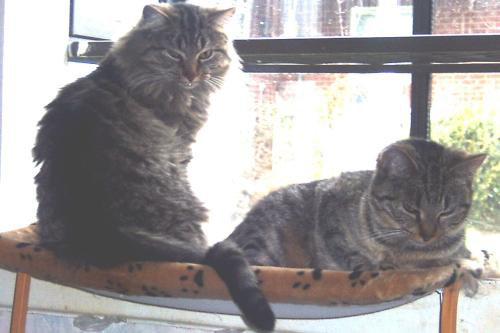

In [34]:
root = '../Data/CATS_DOGS/CATS_DOGS/test/'
category = 'Cat'  # or 'Dog', depending on which category you want

# Get a list of all image files in the specified category folder
category_folder = os.path.join(root, category)
image_files = [f for f in os.listdir(category_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

if image_files:
    # Choose the first image in the list (you can modify this as needed)
    chosen_image = image_files[2020]

    # Load the chosen image
    image_path = os.path.join(category_folder, chosen_image)
    image = Image.open(image_path)

    # Display the image within the notebook
    display(image)
else:
    print(f"No images found in the '{category}' category.")


We have displayed the image from our local directory.

In [30]:
# CNN Model Prediction:
x = 2020
CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 DOG


Here we can our CNN Model is predicting that it's a DOG, Which is wrong because our CNN Model is not accurate as AlexNet Model.

In [31]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


So our AlexNet Model predicted that it is CAT which is correct so here we can see that using PreTrained Model have more accuracy.

##  Thank You